# Анализ бизнес-метрик развлекательного приложения

## 1. Вводные
### 1.1. Задача

Бизнес развлекательного приложения несколько прошлых месяцев постоянно нес убытки: в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.

В распоряжении есть:

- лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27,
- выгрузка их покупок за этот период,
- статистика рекламных расходов.

Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов,
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### 1.2. Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## 2. Обзор и предобработка данных
### 2.1. Подготовка к анализу и загрузка данных 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'  # переключаем на векторную графику

import warnings
warnings.simplefilter('ignore')  # отключаем предупредения Anaconda

In [2]:
# Локальные адреса файлов
try:
    visits_df = pd.read_csv('visits_info_short.csv')
    orders_df = pd.read_csv('orders_info_short.csv')
    costs_df = pd.read_csv('costs_info_short.csv')

# Адреса в тренажёре
except:  
    visits_df = pd.read_csv('/datasets/visits_info_short.csv')
    orders_df = pd.read_csv('/datasets/orders_info_short.csv')
    costs_df = pd.read_csv('/datasets/costs_info_short.csv')

### 2.2. Визиты

In [3]:
visits_df.info()
visits_df.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
266002,451978401658,UK,iPhone,organic,2019-08-22 06:35:10,2019-08-22 06:43:22


In [4]:
# Приведём названия столбцов в snake_case
visits_df.rename(columns={
    'User Id': 'user_id',
    'Region': 'region',
    'Device': 'device',
    'Channel': 'channel',
    'Session Start': 'session_start',
    'Session End': 'session_end'
}, inplace=True)

visits_df.sample()

,user_id,region,device,channel,session_start,session_end
76873,530269227485,United States,Mac,FaceBoom,2019-07-15 15:01:26,2019-07-15 15:16:21


In [5]:
# Преобразуем типы старта и конца сессий в datetime
visits_df['session_start'] = pd.to_datetime(visits_df['session_start'])
visits_df['session_end'] = pd.to_datetime(visits_df['session_end'])

visits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [6]:
# Проверим наличие дубликатов в категориальных переменных
for column in ['region', 'device', 'channel']:
    print(column, visits_df[column].value_counts(), '', sep='\n')

region
United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

device
iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

channel
organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64



In [7]:
# Проверим наличие явных дубликатов строк
visits_df.duplicated().sum()

0

In [8]:
# Валидации
visits_df.query("session_start > session_end")

,user_id,region,device,channel,session_start,session_end


array([[<AxesSubplot:title={'center':'session_start'}>,
        <AxesSubplot:title={'center':'session_end'}>]], dtype=object)

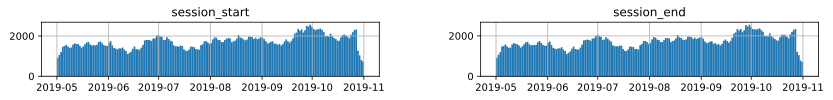

In [9]:
# Посмотрим как выглядят сессии во времени
visits_df[['session_start', 'session_end']].hist(bins=180, figsize=(14, 1), sharex=True)

<AxesSubplot:>

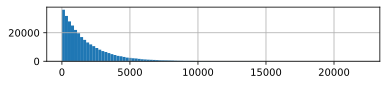

In [10]:
# А также на их продолжительность
visits_df['duration'] = (visits_df['session_end'] - visits_df['session_start'])
visits_df['duration'].dt.seconds.hist(bins=100, figsize=(6, 1))

Пропусков и дубликатов в данных нет. 

Явных аномалий также не обнаружено:
- время старта сессии всега меньше времени конца;
- визиты распределены относительно монотонно по дням исследуемого отрезка, со временем растут;
- много коротких визитов, и чем больше длительность визита, тем меньше таких сессий.

### 2.3. Заказы

In [11]:
orders_df.info()
orders_df.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
23240,212510001442,2019-10-09 02:23:16,4.99


In [12]:
# Приведём названия столбцов в snake_case
orders_df.rename(columns={
    'User Id': 'user_id',
    'Event Dt': 'event_dt',
    'Revenue': 'revenue'
}, inplace=True)

orders_df.sample()

,user_id,event_dt,revenue
36475,147993878118,2019-09-24 09:07:26,4.99


In [13]:
# Преобразуем тип event_dt в datetime
orders_df['event_dt'] = pd.to_datetime(orders_df['event_dt'])

orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [14]:
# Проверим наличие явных дубликатов строк
orders_df.duplicated().sum()

0

In [15]:
# Валидации
orders_df.query('revenue <= 0')

,user_id,event_dt,revenue


<AxesSubplot:>

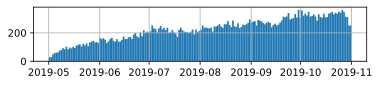

In [16]:
# Посмотрим как выглядят покупки во времени
orders_df['event_dt'].hist(bins=180, figsize=(6, 1))

In [17]:
# Посмотрим, много ли вариантов покупок есть в приложении
orders_df.value_counts('revenue')

revenue
4.99     38631
5.99       780
9.99       385
49.99      212
19.99      204
dtype: int64

Пропусков и дубликатов в данных нет. 

Явных аномалий также не обнаружено:
- выручка всегда положительна;
- оплаты распределены относительно монотонно по дням исследуемого отрезка, со временем их количество растёт;
- в основном делают дешёвые покупки, чем больше сумма, тем меньше таких покупок, за исключением самой дорогой покупки вроде «all inclusive», но количество таких покупок вполне укладывается в картину реальности.

### 2.4. Затраты на маркетинг

In [18]:
costs_df.info()
costs_df.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
193,2019-05-14,MediaTornado,7.2


In [19]:
# Приведём названия столбцов в snake_case
costs_df.rename(columns={
    'Channel': 'channel'
}, inplace=True)

costs_df.sample()

,dt,channel,costs
1529,2019-07-29,WahooNetBanner,24.0


In [20]:
# Преобразуем тип dt в datetime.date
costs_df['dt'] = pd.to_datetime(costs_df['dt']).dt.date

costs_df.info()
costs_df.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,channel,costs
1263,2019-05-04,OppleCreativeMedia,4.25


In [21]:
# Проверим, что тип dt object — именно объект даты
(costs_df['dt'] - costs_df['dt']).sample()

237   0 days
Name: dt, dtype: timedelta64[ns]

In [22]:
# Проверим наличие дубликатов в channel
costs_df['channel'].value_counts()

FaceBoom              180
MediaTornado          180
RocketSuperAds        180
TipTop                180
YRabbit               180
AdNonSense            180
LeapBob               180
OppleCreativeMedia    180
WahooNetBanner        180
lambdaMediaAds        180
Name: channel, dtype: int64

In [23]:
# Проверим наличие явных дубликатов строк
costs_df.duplicated().sum()

0

In [24]:
# Проверим, что в costs_df и visits_df используются те же названия каналов
set(visits_df['channel'].unique()) - set(costs_df['channel'].unique())

{'organic'}

In [25]:
# Валидации
costs_df.query('costs <= 0')

,dt,channel,costs


<AxesSubplot:>

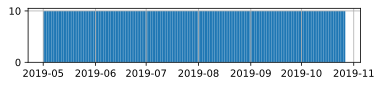

In [26]:
# Посмотрим как выглядят затраты на рекламу во времени
costs_df['dt'].hist(bins=180, figsize=(6, 1))

<AxesSubplot:>

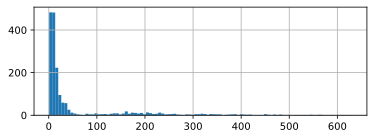

In [27]:
# Посмотрим, как распределены суммы дневных бюджетов на канал
costs_df['costs'].hist(bins=100, figsize=(6, 2))

Пропусков и дубликатов в данных нет. 

Явных аномалий также не обнаружено:
- затраты всегда положительны;
- есть данные о закупках рекламы за каждый день в каждом канале;
- в основном бюджет на день небольшой, вероятно есть много дней, в которые в ряде каналов ничего не закупали; аномально крупных вложений в маркетинг в день не видно.

## 3. Подготовка функций для расчета и анализа LTV, ROI, Retention и конверсии

In [28]:
# Функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # Находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # Для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # Добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # Добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # Считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # Объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # Делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # Добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # Стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [29]:
# Функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [30]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [31]:
# Функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # Добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # Рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # Группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # Функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # Строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # Находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # Вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # Объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # Считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # Исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # Восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # Собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # Считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # Считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # Удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # Восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # Добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # В финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # Возвращаем таблицы LTV и ROI
        return result, roi

    # Получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # Для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # Получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,      # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,     # таблица ROI
        roi_in_time,     # таблица динамики ROI
    ) 

In [32]:
# Функция для сглаживания фрейма

def filter_data(df, window):
    # Для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window, min_periods=1).mean() 
    return df 

In [33]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7, size=(10, 6)):

    # задаём размер сетки для графиков
    plt.figure(figsize=size)

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [34]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7, size=(10, 3)):

    # задаём размер сетки для графиков
    plt.figure(figsize=size)

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [35]:
# функция для визуализации LTV и ROI без разбивки по дополнительным признакам

def plot_ltv_roi_no_dim(ltv, ltv_history, roi, roi_history, horizon, window=7, size=(10, 6)):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=size)

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv и cac
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    # строим график LTV на 'horizon' день
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).rename(columns={horizon - 1: 'lvt'})
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    
    # строим график CAC
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день и САС'.format(horizon))

    # третий график — кривые roi
    ax4 = plt.subplot(2, 2, 3)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # четвёртый график — динамика roi
    ax5 = plt.subplot(2, 2, 4, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).rename(columns={horizon - 1: 'roi'})
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [36]:
# Функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7, size=(10, 20)):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=size)

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(4, 1, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv и cac
    ax2 = plt.subplot(4, 1, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    # переименуем столбцы для легенды, так как на одном графике отображаем и ltv, и cac
    ltv_lables = []
    for i in range(len(filtered_data.columns)):
        ltv_lables.append('ltv ' + filtered_data.columns[i])
    filtered_data.columns = ltv_lables
    # строим графики ltv
    filter_data(filtered_data, window).plot(grid=True, ax=ax2, colormap='tab10')
 
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    # переименуем столбцы для легенды
    cac_lables = []
    for i in range(len(filtered_data.columns)):
        cac_lables.append('cac ' + filtered_data.columns[i])
    filtered_data.columns = cac_lables
    # строим графики cac
    filter_data(filtered_data, window).plot(grid=True, ax=ax2, style=':', linewidth=1.7, colormap='tab10')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день и CAC'.format(horizon))

    # четвёртый график — кривые roi
    ax4 = plt.subplot(4, 1, 3)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(4, 1, 4, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## 4. Исследовательский анализ данных

### 4.1. Пользователи

#### 4.1.1. Подготовка и обзор данных

In [37]:
# Посмтроим профили пользователей
profiles_df = get_profiles(visits_df, orders_df, [], costs_df)
profiles_df.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [38]:
# Посмотрим, сколько уникальных пользователей, сколько платящих и какая их доля
users = profiles_df.shape[0]
payers = profiles_df.query("payer == True").shape[0]
users, payers, payers / users

(150008, 8881, 0.05920350914617887)

In [39]:
# Определим минимальную и максимальную даты привлечения пользователей

""" Вообще-то даты привлечения пользователей нам не известны.
    Известны только даты оплат, старта и конца сессий за определённый период.
    Будем считать датой привлечения дату первой сессии пользователя в этом периоде.
"""

min_aquisition_date = profiles_df['dt'].min()
max_aquisition_date = profiles_df['dt'].max()

min_aquisition_date, max_aquisition_date

(datetime.date(2019, 5, 1), datetime.date(2019, 10, 27))

#### 4.1.2. Страны

In [40]:
# Посмотрим, из каких стран пользователи приходят в приложение
# и на какую страну приходится больше всего платящих пользователей

def payer_share(profiles_df, key):
    result_df = (
        profiles_df.groupby(key).agg({'payer': 'mean'})
        .sort_values(by='payer', ascending=False)
        .join(profiles_df[key].value_counts(), on=key)
        .rename(columns={key: 'users_total', 'payer': 'payer_share'})
        .join(profiles_df.query("payer == True")[key].value_counts(), on=key)
        .rename(columns={key: 'paying_users'})
    )
    display(result_df)    
    
    plt.figure(figsize=(8, 4))
    
    for i, column in enumerate(['users_total', 'paying_users']):
        ax = plt.subplot(1, 2, i+1)
        result_df.sort_values(by=column, ascending=False)[column].plot.pie(
            legend=False,
            autopct='%1.0f%%',
            colormap='Set3',
            title=column,
            ax=ax,
        )
        plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
    return result_df

,payer_share,users_total,paying_users
region,,,
United States,0.069019,100002,6902
Germany,0.041119,14981,616
UK,0.039829,17575,700
France,0.037994,17450,663


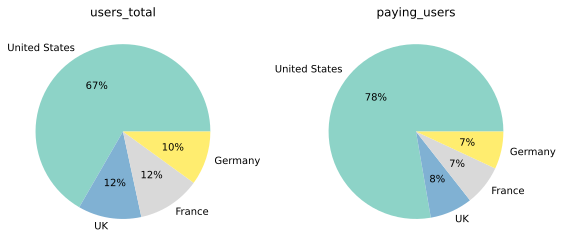

In [41]:
regions_df = payer_share(profiles_df, 'region')

#### 4.1.3. Устройства

,payer_share,users_total,paying_users
device,,,
Mac,0.063644,30042,1912
iPhone,0.062079,54479,3382
Android,0.058518,35032,2050
PC,0.050468,30455,1537


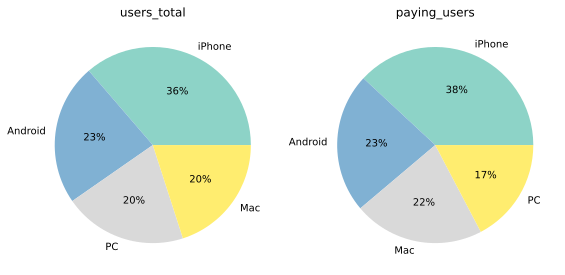

In [42]:
# Узнайем, какими устройствами пользуются клиенты
# и какие устройства предпочитают платящие пользователи.
devices_df = payer_share(profiles_df, 'device')

#### 4.1.4. Каналы привлечения

,payer_share,users_total,paying_users
channel,,,
FaceBoom,0.122049,29144,3557
AdNonSense,0.113402,3880,440
lambdaMediaAds,0.104700,2149,225
TipTop,0.096007,19561,1878
RocketSuperAds,0.079137,4448,352
WahooNetBanner,0.052964,8553,453
YRabbit,0.038265,4312,165
MediaTornado,0.035747,4364,156
LeapBob,0.030633,8553,262


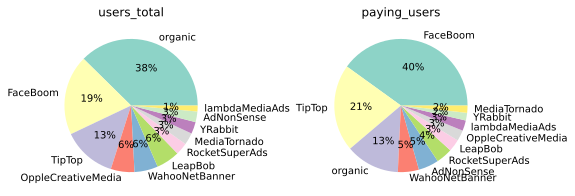

In [43]:
# Найдём каналы, из которых пришло больше всего платящих пользователей
channels_df = payer_share(profiles_df, 'channel')

#### 4.1.5. Выводы о пользователях
Основная доля пользователей — из США (67%), при этом там наибольшая доля платящих пользователей (6,9%).

Больше всего пользователей пришли с айфона (36%), там хорошая доля платящих (6,2%), больше только у пользователей с макбуками (6,4%). Стоит отметить, что 2/5 пользователей приходят с десктопа и 3/5 — с мобильных.

Самый крупный канал привлечения — органика (38%), но доля плятящих там самая низкая (2%).

Из платных каналов в лидерах FaceBoom и по объёму привлечённых пользователей (19%), и по доле плятящих (12,2%). Также TipTop — довольно крупный канал (13%) с неплохой долей платящих (9,6%).

### 4.2. Маркетинговые расходы

#### 4.2.1. Общие расходы

Выясните, как траты распределены по источникам.

Визуализируйте изменения метрик во времени.

In [44]:
# Посчитаем общую сумму расходов на маркетинг
costs_df['costs'].sum()

105497.30000000002

In [45]:
# Рассчитаем расходы по каналам
channels_df = (
    channels_df.join(costs_df.groupby(by='channel').agg({'costs': 'sum'}))
    .rename(columns={'costs': 'costs_total'})
).fillna(0)

channels_df

,payer_share,users_total,paying_users,costs_total
channel,,,,
FaceBoom,0.122049,29144,3557,32445.60
AdNonSense,0.113402,3880,440,3911.25
lambdaMediaAds,0.104700,2149,225,1557.60
TipTop,0.096007,19561,1878,54751.30
RocketSuperAds,0.079137,4448,352,1833.00
WahooNetBanner,0.052964,8553,453,5151.00
YRabbit,0.038265,4312,165,944.22
MediaTornado,0.035747,4364,156,954.48
LeapBob,0.030633,8553,262,1797.60


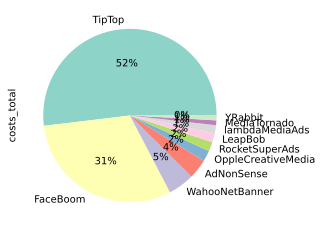

In [46]:
channels_df.sort_values(by='costs_total', ascending=False)['costs_total'].plot.pie(
    legend=False,
    autopct='%1.0f%%',
    colormap='Set3',
)
plt.show()

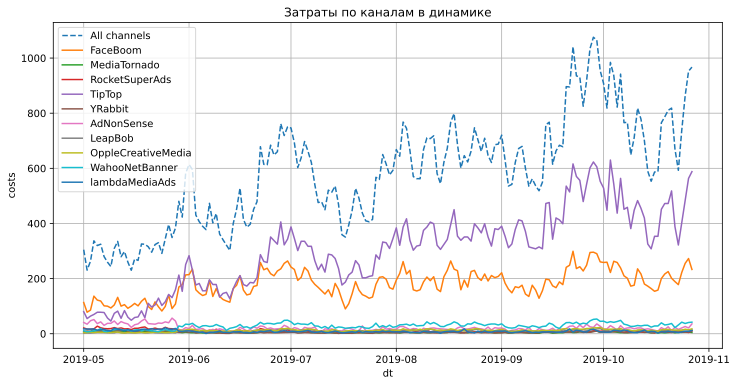

In [47]:
# Визуализируем изменения затрат во времени
plt.figure(figsize=(12, 6))

sum_costs = costs_df.groupby('dt').agg({'costs': 'sum'}).reset_index()
plt.plot(sum_costs['dt'], sum_costs['costs'], label='All channels', linestyle='--')

for channel in costs_df['channel'].unique():
    channel_costs = costs_df.query("channel == @channel")
    plt.plot(channel_costs['dt'], channel_costs['costs'], label=channel)
    
plt.title('Затраты по каналам в динамике')
plt.xlabel('dt')
plt.ylabel('costs')
plt.legend()
plt.grid()

plt.show()

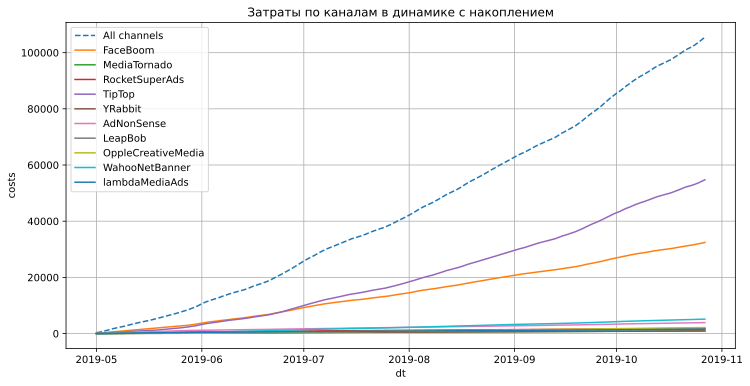

In [48]:
# Визуализируем изменения затрат во времени
plt.figure(figsize=(12, 6))

cumsum_costs = costs_df.groupby('dt').agg({'costs': 'sum'}).reset_index()

for i in range(1, len(sum_costs)):
    cumsum_costs['costs'][i] += cumsum_costs['costs'][i-1]
plt.plot(cumsum_costs['dt'], cumsum_costs['costs'], label='All channels', linestyle='--')

for channel in costs_df['channel'].unique():
    channel_cum_costs = costs_df.query("channel == @channel").reset_index(drop=True)
    for i in range(1, len(channel_cum_costs)):
        channel_cum_costs['costs'][i] += channel_cum_costs['costs'][i-1]
    plt.plot(channel_cum_costs['dt'], channel_cum_costs['costs'], label=channel)
    
plt.title('Затраты по каналам в динамике c накоплением')
plt.xlabel('dt')
plt.ylabel('costs')
plt.legend()
plt.grid()

plt.show()

#### 4.2.2. Расход на пользователя

In [49]:
# Рассчитаем CAC по каналам
channels_df['cac'] = channels_df['costs_total'] / channels_df['users_total']
channels_df.sort_values(by='cac')

,payer_share,users_total,paying_users,costs_total,cac
channel,,,,,
organic,0.020553,56439,1160,0.00,0.000000
LeapBob,0.030633,8553,262,1797.60,0.210172
MediaTornado,0.035747,4364,156,954.48,0.218717
YRabbit,0.038265,4312,165,944.22,0.218975
OppleCreativeMedia,0.027077,8605,233,2151.25,0.250000
RocketSuperAds,0.079137,4448,352,1833.00,0.412095
WahooNetBanner,0.052964,8553,453,5151.00,0.602245
lambdaMediaAds,0.104700,2149,225,1557.60,0.724802
AdNonSense,0.113402,3880,440,3911.25,1.008054


In [50]:
# И CAC всего платного трафика
paying_channels_df = channels_df.query("channel != 'organic'")
cac_avg = paying_channels_df['costs_total'].sum() / paying_channels_df['users_total'].sum()
cac_avg

1.1274813239427588

#### 4.2.3. Выводы о маркетинговых расходах

Всего за рассматриваемый период было потрачено ≈105 500 на платные каналы привлечения пользователей.

(Валюта не указана, видимо, долларов, но знак $ я не буду использовать потому что его повторное использование, даже с обратным слешем, воспринимается как разметка, не разобрался пока, как это победить)

Основные каналы по сумме затрат: 
- TipTop (52%)
- FaceBoom (31%)

На остальные каналы потрачено 5% или меньше от бюджета за период.

Расходы на трафик постепенно растут. В начале мая они составляли ≈300/день, в сентябре-октябре уже ≈800/день.

Средняя стоимомть привлечения пользователя из платного канала: ≈1,13

При этом в оснвных используемых каналах она самая высокая:
- TipTop (1,11)
- FaceBoom (2,80)

Самая низкая стоимость привлечения в каналах:
- LeapBob (0,21)
- MediaTornado	(0,22)
- YRabbit (0,22)
- OppleCreativeMedia (0,25)

### 4.3. Окупаемость рекламы
Примем 2 допущения:
1. Сегодня 1 ноября 2019 года.
2. В бизнес-модели заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения

In [51]:
# Зададим дату и горизонт анализа
observation_date = pd.datetime(2019, 11, 1).date()
horizon_days = 14

In [52]:
# Исключим органический трафик, для случаем, когда нас будет интересовать окупаемость платных каналов
paid_profiles_df = profiles_df.query("channel != 'organic'")
paid_users = paid_profiles_df['user_id'].unique()

paid_visits_df = visits_df.query("user_id in @paid_users")
paid_orders_df = orders_df.query("user_id in @paid_users")

#### 4.3.1. Общая окупаемость

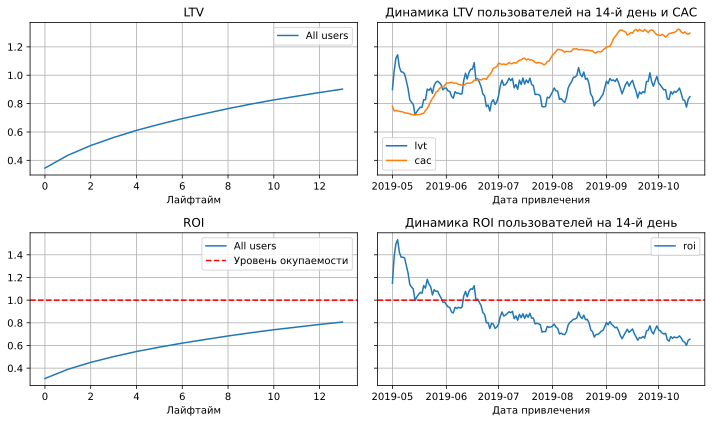

In [53]:
# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(paid_profiles_df,
                                                      paid_orders_df,
                                                      observation_date,
                                                      horizon_days)

plot_ltv_roi_no_dim(ltv, ltv_history, roi, roi_history, horizon_days)

Самые крупные статьи расходов работают неэффективно: как по рекламным каналам, так и по странам. 

До второй декады июня LTV 14-го дня был выше СAC, месяц они были близкими и уже после второй декады июля LTV 14-го дня был стабильно меньше CAC. Соответственно и ROI c этого момента стал ниже 100% и продолжал падать, к ноябрю опустившись до 75%. То есть сейчас на каждый вложенный доллар бизнес возвращает только 75 центов.

#### 4.3.2. Окупаемость по каналам

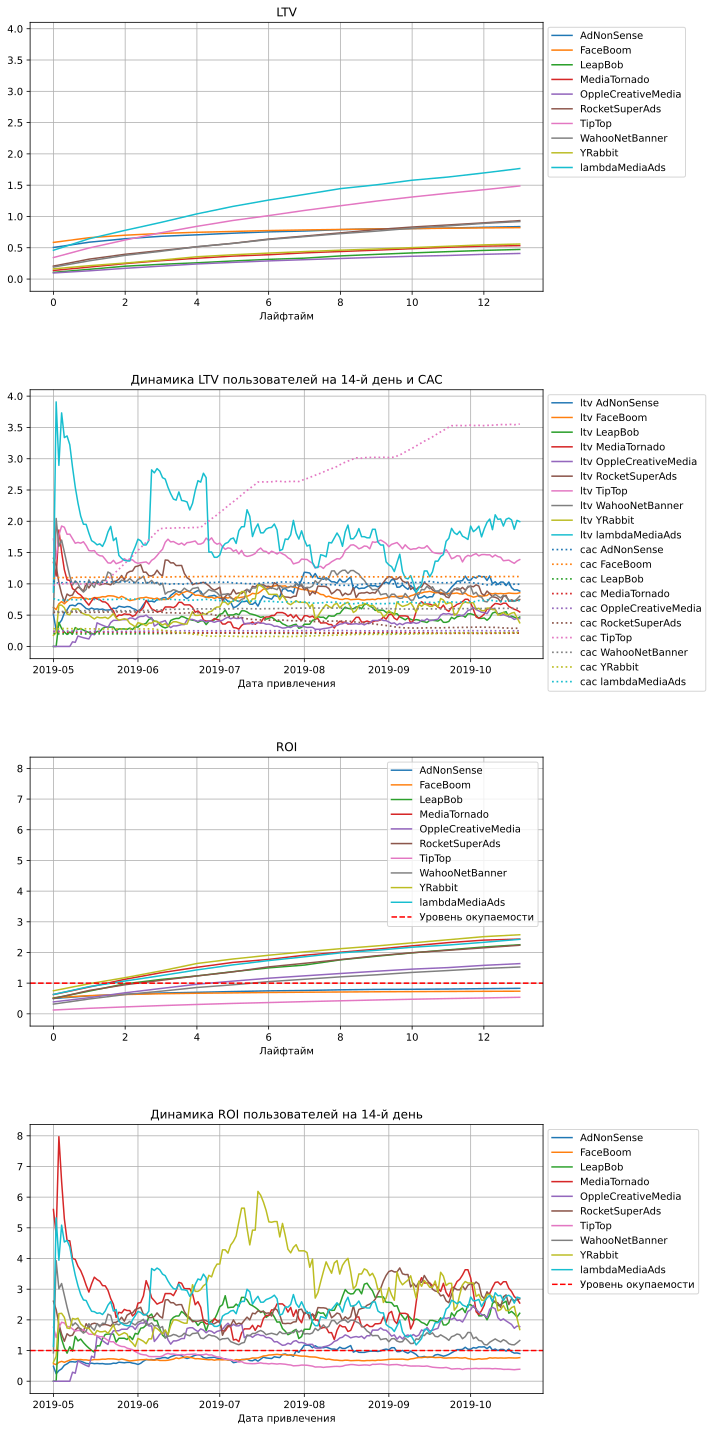

In [54]:
# Построим те же графики с разбивкой по рекламным каналам
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(paid_profiles_df,
                                                      paid_orders_df,
                                                      observation_date,
                                                      horizon_days,
                                                      ['channel'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=21)

Стоимость привлечения во всех каналах приблизительно стабильная, кроме TipTop. Там она с мая по ноябрь выросла с 1 до 3,5.

Каналы, которые «съедают» основной маркетинговый бюджет — убыточны:
- FaceBoom (LTV ≈ 0,8; CAC ≈ 1,15) — 52% бюджета
- TipTop (LTV ≈ 1,5; CAC ≈ 3,5) — 31% бюджета
- AdNonSense (LTV ≈ 0,9; CAC ≈ 1)  — 4% бюджета

#### 4.3.3. Окупаемость по странам

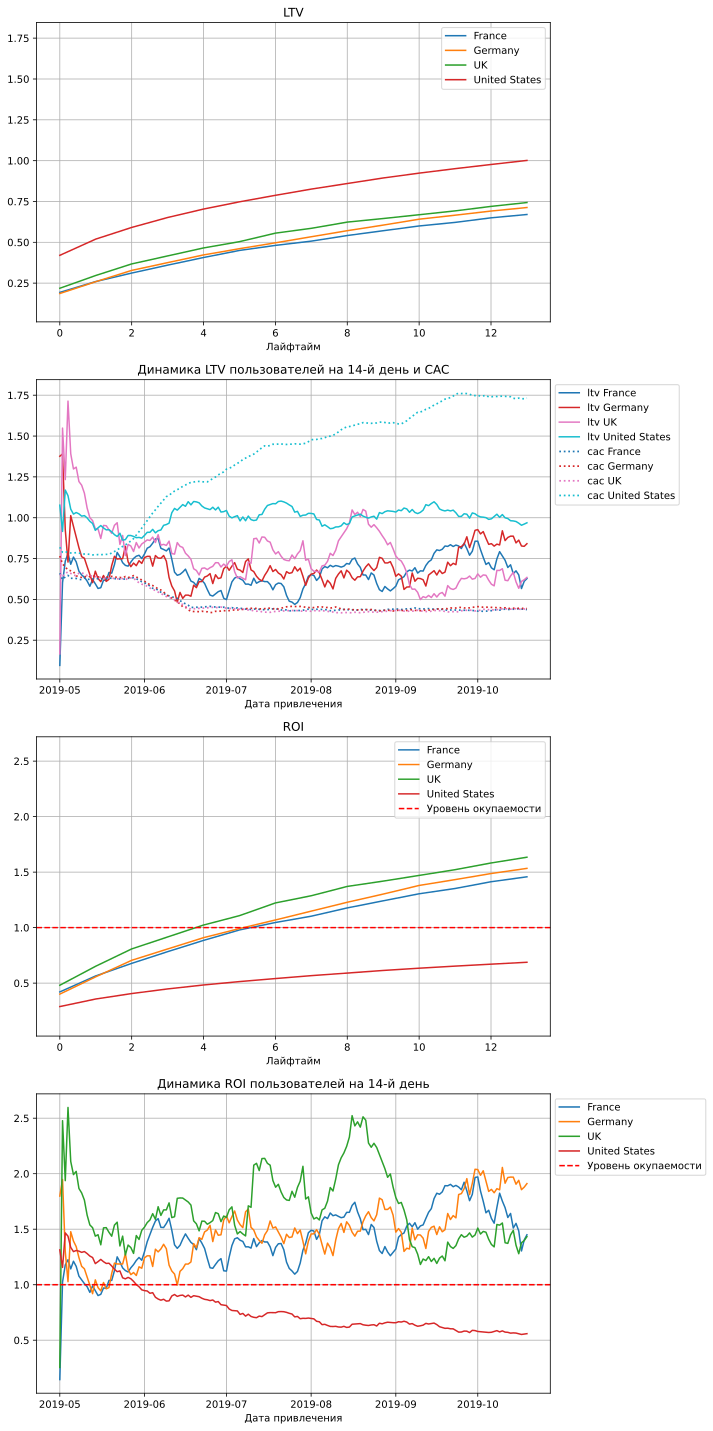

In [55]:
# Построим те же графики с разбивкой по странам
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(paid_profiles_df,
                                                      paid_orders_df,
                                                      observation_date,
                                                      horizon_days,
                                                      ['region'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=21)

Стоимость привлечения в Европе стабильна и примерно одинакова, CAC ≈ 0,3. При этом LTV всегда был в диапазоне от 0,4 до 0,8. В Европе бизнес прибылен. 

В США до конца июня LTV был выше CAC, при этом оба росли с мая. Но с июля CAC продолжил расти и достиг ≈1,15, а LTV практически перестал расти и остался ниже 0,8. Здесь вложения в маркетинг с июля убыточны. 

#### 4.3.4. Окупаемость по устройствам

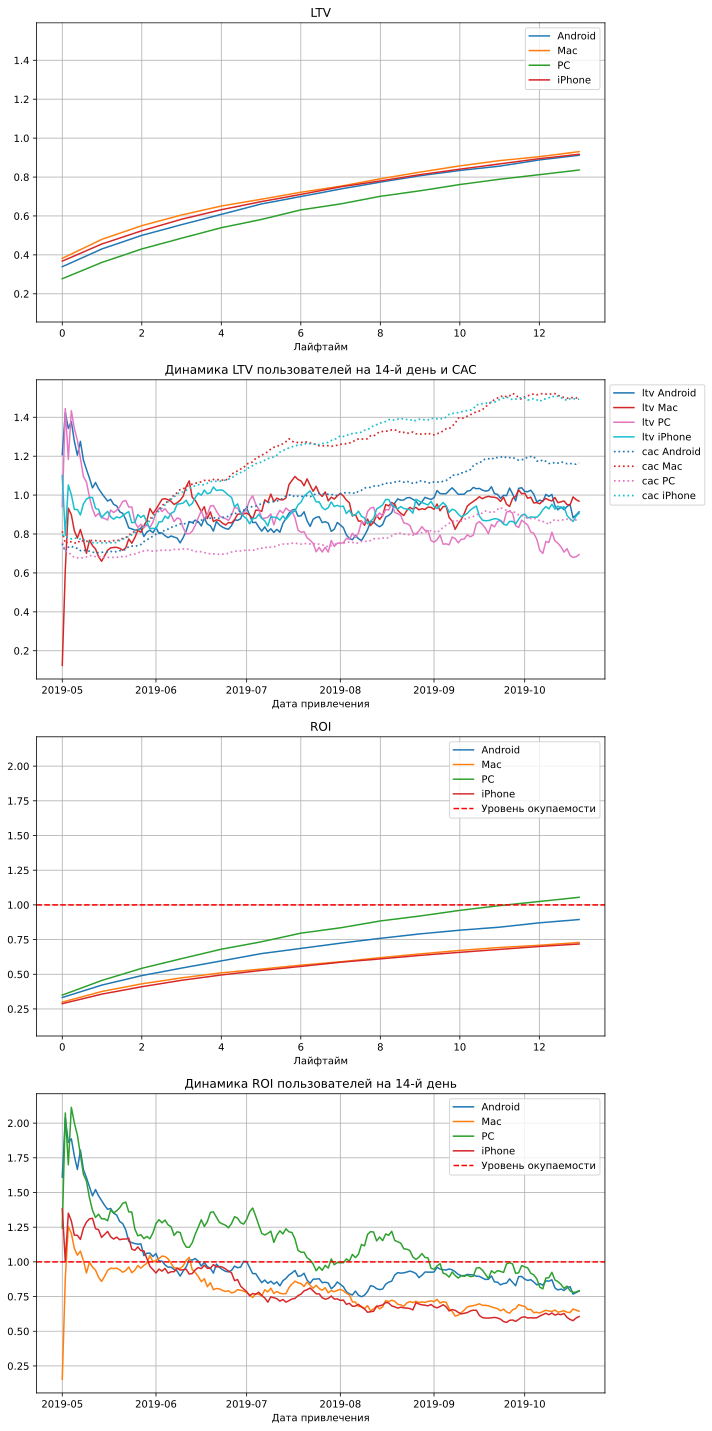

In [56]:
# Построим те же графики с разбивкой по девайсам
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(paid_profiles_df,
                                                      paid_orders_df,
                                                      observation_date,
                                                      horizon_days,
                                                      ['device'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=21)

Окупаемость рекламы лучше на PC и андроиде, но не факт, что прямо сейчас нужно на это реагировать. Вероятно, просто в США в среднем чаще пользются техникой Apple.

### 4.4. Удержание

#### 4.4.1. Удержание в разбивке по каналам

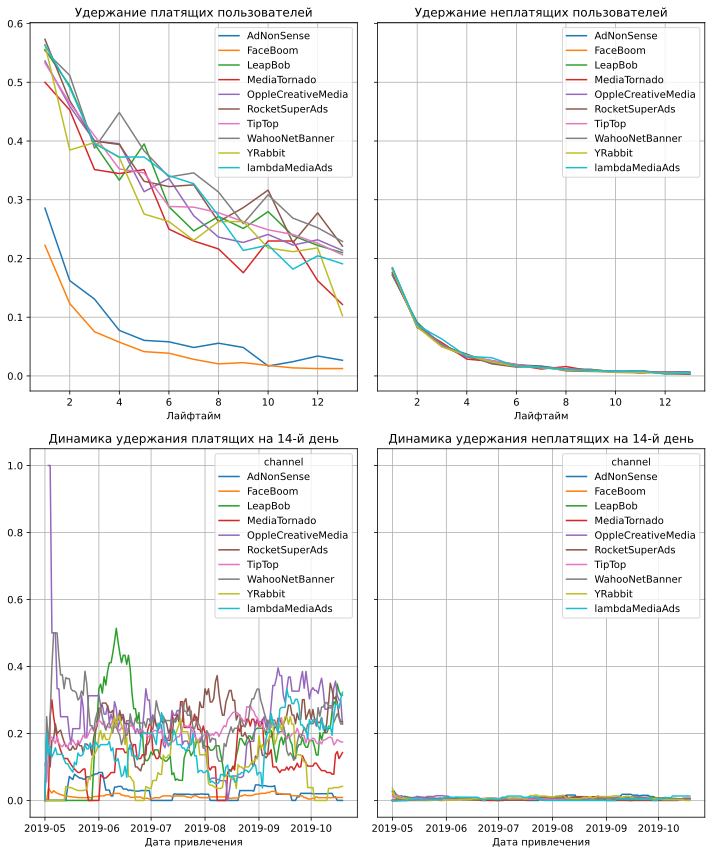

In [57]:
# Построим графики удержания с разбивкой по каналам
retention_raw, retention, retention_history = get_retention(paid_profiles_df,
                                                            paid_visits_df,
                                                            observation_date,
                                                            horizon_days,
                                                            ['channel'])
plot_retention(retention, retention_history, horizon_days, window=21, size=(10, 12))

Заметно хуже удержание платящих в каналах AdNonSense и FaceBoom. У остальных — примерно на одном уровне.

Хороший рост удержания на 14-й день и рекордное удержание на 14-й день показывал LeapBob c конца мая по середину июня.
К середине августа упало, но потом хорошо выросло удержание в OppleCreativeMedia.
В YMedia удержание нестабильное и в октябре сильно упало. 

#### 4.4.2. Удержание в разбивке по странам

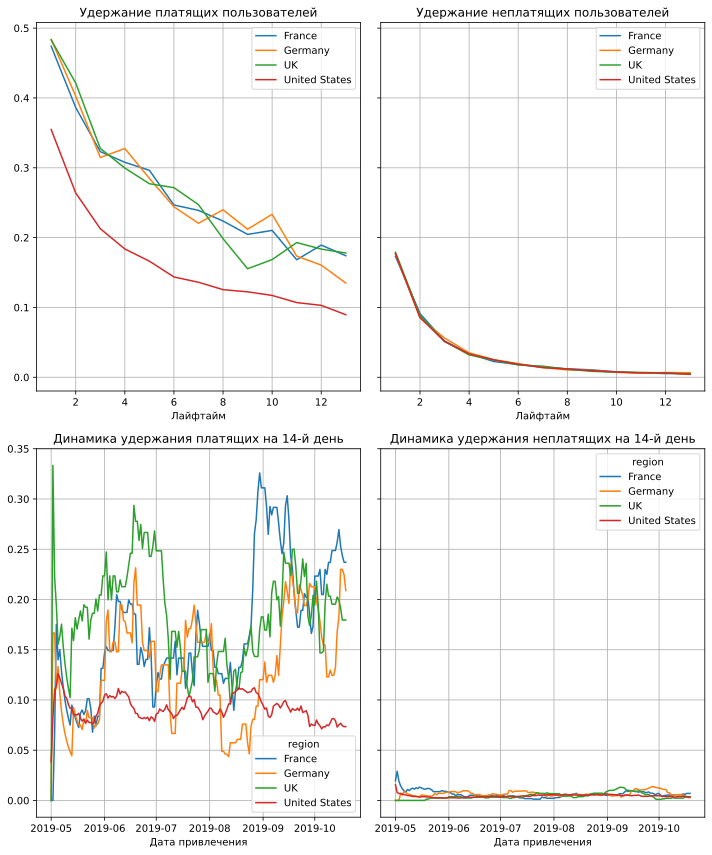

In [58]:
# Построим графики удержания с разбивкой по странам
retention_raw, retention, retention_history = get_retention(paid_profiles_df,
                                                            paid_visits_df,
                                                            observation_date,
                                                            horizon_days,
                                                            ['region'])
plot_retention(retention, retention_history, horizon_days, window=21, size=(10, 12))

Хуже всего ужерживаются платящие пользователи из США. В других странах удержание примерно одинаковое, но в Британии с 8-го дня после привлечения и начинает восстанавливаться с 10-го, к 12-му приобретает характер измениния, похожий на другие европейские страны.

Динамика удержания на 14-й день в странах имеет разный характер.
В Британии удержание хорошо росло с мая, но с июля резко упало, начало восстанавливаться с середины августа, а с середины сентября опять падает.
Во Франции было три момента, когда удержание резко росло: конец мая — начало июня, вторая половина августа (!), начало октября.
В Германии особенно нестабильный график, рост: конец мая, вторая декада июля, конец августа, середина сентября и середина октября. Сильные падения: с середины июня по середину июля, начало августа, начало октября.
В США динамика относительно стабильная.

#### 4.4.3. Удержание в разбивке по устройствам

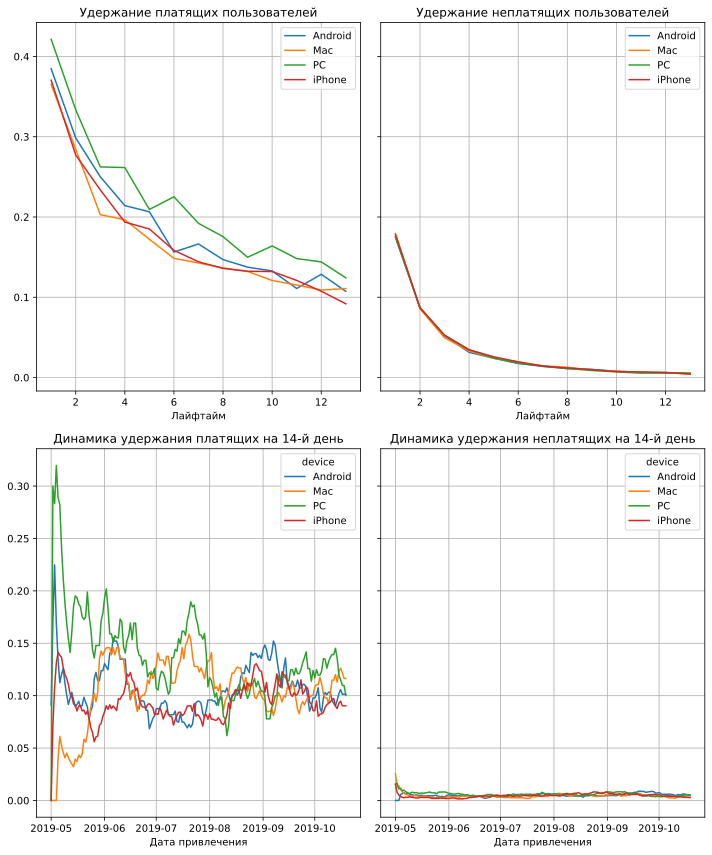

In [59]:
# Построим графики удержания с разбивкой по устройствам
retention_raw, retention, retention_history = get_retention(paid_profiles_df,
                                                            paid_visits_df,
                                                            observation_date,
                                                            horizon_days,
                                                            ['device'])
plot_retention(retention, retention_history, horizon_days, window=21, size=(10, 12))

Лучшее удержание платящих пользователей показывает PC, чуть хуже Android. Пользователи на Mac и Android ужерживаются примерно одинаково и хуже всего. Неплатящие удерживаются примерно одинаково независимо от платформы.

Примерно 10 июля что-то произошло с удержанием 14-го дня плятящих пользователей: что вырастило его на всех платформах, кроме андроида, там оно даже упало. Но потом 20 июля произошёл обратный эффект и удержание начало падать на десктопах и айфоне, а на андроиде — расти. Примерно после 10 августа был заметный рост удержания на всех платформах. Возможно, этому что-то поспособствовало, на что бизнес умеет влиять. Также в начале сентября что-то уронило ретенш примерно на неделю.

### 4.5. Конверсия

#### 4.5.1. Конверсия в разбивке по каналам

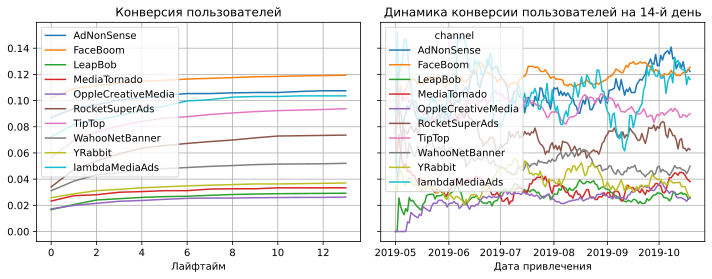

In [60]:
# Построим графики конверсии с разбивкой по каналам
conversion_raw, conversion, conversion_history = get_conversion(paid_profiles_df,
                                                                paid_orders_df,
                                                                observation_date,
                                                                horizon_days,
                                                                ['channel'])    
plot_conversion(conversion, conversion_history, horizon_days, window=21, size=(10, 4))

Трафик лучше всего конвертируется в покупку в FaceBoom. Хорошо: в AdNonSense, lambdaMediaAds и TipTop. Хуже всего: YRabbit, MediaTornado, LeapBob, OppleCreativeMedia.

В lambdaMediaAds было сильное падение конверсии с конца августа по 10 сентября. И потом — отскок до 20 сентября.

#### 4.5.2. Конверсия в разбивке по странам

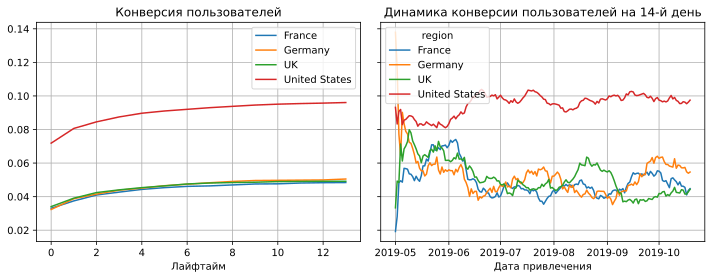

In [61]:
# Построим графики конверсии с разбивкой по странам
conversion_raw, conversion, conversion_history = get_conversion(paid_profiles_df,
                                                                paid_orders_df,
                                                                observation_date,
                                                                horizon_days,
                                                                ['region'])    
plot_conversion(conversion, conversion_history, horizon_days, window=21, size=(10, 4))

В США конверсия почти в 2 раза выше, чем в Европе. В Европейских странах — одинаковая.

За июнь конверсия в Штатах заметно выросла. А в европейских странах — упала. Стоит помнить, что мы всегда говорим о конверсии 14-го дня. В начале сентября что-то уронило конверсию в Британии. Но в Германии и Франции весь сентябрь она росла.

#### 4.5.3. Конверсия в разбивке по устройствам

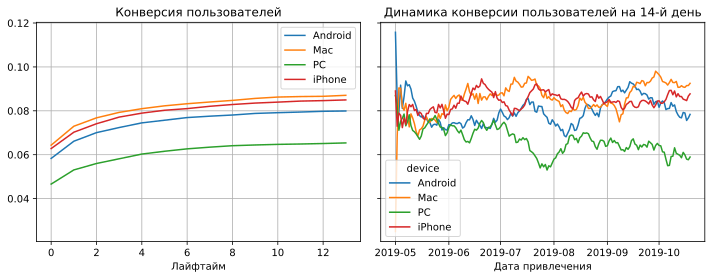

In [62]:
# Построим графики конверсии с разбивкой по устройствам
conversion_raw, conversion, conversion_history = get_conversion(paid_profiles_df,
                                                                paid_orders_df,
                                                                observation_date,
                                                                horizon_days,
                                                                ['device'])    
plot_conversion(conversion, conversion_history, horizon_days, window=21, size=(10, 4))

На PC конверсия заметно ниже, чем на других устройствах. Андроид остаёт от платформ Эппла. Мак чуть лучше айфона.

На PC конверсия 14-го дня заметно падала весь июль. На других устройствах с задержкой в 2 недели: с середины июля по середину августа. В последний месяц конверсии на маке и айфоне медленно растут, а на PC и андроиде падают.

## 5. Выводы
### 5.1. Основное
В целом реклама не окупается.

Самые проблемные места: США, FaceBoom, TipTop (+ AdNonSense — слабо убыточен, но незначителен).

Приносят прибыль: Европа, Мелкие каналы. 

Лучшие каналы привлечения: YRabbit, MediaTornado, LambdaMediaAds, LeapBob, RocketSuperAds.

Окупаемость рекламы лучше на PC и андроиде, но не факт, что прямо сейчас нужно на это реагировать. Вероятно, просто в США в среднем чаще пользются техникой Apple.

Рекомендации:
- значительно сократить или остановить вложения в США, FaceBoom, TipTop и AdNonSense;
- тестировать гипотезы продвижения в США и убыточных каналах на малых бюджетах, пока они не покажут прибыльную экономику;
- масштабировать Европу и остальные каналы, аккуратно, следя за метриками;
- проанализировать кампании и измениния конверсионных элементов: что вызывало рост, а что падение по динамике или отдельно, выгрузив данные по кампаниям;
- искать точки роста удержания, обратив внимание на пользовательский опыт на PC и андроиде. Подтянуть конверсию в США, изучив опыт Европы, а возможно, кастомизировав локальный подход в Штатах, изменив коммуникацию и продуктовый опыт.
- искать точки роста конверсии, изучив проблемы на PC и в Европе + успехи мака, айфона и США. Возможно стоит локалазировать кампании и коммуникацию в Европе.


### 5.2. Пользователи

Основная доля пользователей — из США (67%), при этом там наибольшая доля платящих пользователей (6,9%).

Больше всего пользователей пришли с айфона (36%), там хорошая доля платящих (6,2%), больше только у пользователей с макбуками (6,4%). Стоит отметить, что 2/5 пользователей приходят с десктопа и 3/5 — с мобильных.

Самый крупный канал привлечения — органика (38%), но доля плятящих там самая низкая (2%).

Из платных каналов в лидерах FaceBoom и по объёму привлечённых пользователей (19%), и по доле плятящих (12,2%). Также TipTop — довольно крупный канал (13%) с неплохой долей платящих (9,6%).

### 5.3. Расходы на маркетинг

Всего за рассматриваемый период было потрачено ≈105 500 на платные каналы привлечения пользователей.

Основные каналы по сумме затрат: 
- TipTop (52%)
- FaceBoom (31%)

На остальные каналы потрачено 5% или меньше от бюджета за период.

Расходы на трафик постепенно растут. В начале мая они составляли ≈300/день, в сентябре-октябре уже ≈800/день.

Средняя стоимомть привлечения пользователя из платного канала: ≈1,13

При этом в оснвных используемых каналах она самая высокая:
- TipTop (1,11)
- FaceBoom (2,80)

Самая низкая стоимость привлечения в каналах:
- LeapBob (0,21)
- MediaTornado	(0,22)
- YRabbit (0,22)
- OppleCreativeMedia (0,25)

### 5.4. Окупаемость

Самые крупные статьи расходов работают неэффективно: как по рекламным каналам, так и по странам.

До второй декады июня LTV 14-го дня был выше СAC, месяц они были близкими и уже после второй декады июля LTV 14-го дня был стабильно меньше CAC. Соответственно и ROI c этого момента стал ниже 100% и продолжал падать, к ноябрю опустившись до 75%. То есть сейчас на каждый вложенный доллар бизнес возвращает только 75 центов.

Стоимость привлечения во всех каналах приблизительно стабильная, кроме TipTop. Там она с мая по ноябрь выросла с 1 до 3,5.

Каналы, которые «съедают» основной маркетинговый бюджет — убыточны:

FaceBoom (LTV ≈ 0,8; CAC ≈ 1,15) — 52% бюджета
TipTop (LTV ≈ 1,5; CAC ≈ 3,5) — 31% бюджета
AdNonSense (LTV ≈ 0,9; CAC ≈ 1) — 4% бюджета
Стоимость привлечения в Европе стабильна и примерно одинакова, CAC ≈ 0,3. При этом LTV всегда был в диапазоне от 0,4 до 0,8. В Европе бизнес прибылен.

В США до конца июня LTV был выше CAC, при этом оба росли с мая. Но с июля CAC продолжил расти и достиг ≈1,15, а LTV практически перестал расти и остался ниже 0,8. Здесь вложения в маркетинг с июля убыточны.

### 5.5. Удержание
#### 5.5.1. Устройства
Лучшее удержание платящих пользователей показывает PC, чуть хуже Android. Пользователи на Mac и Android ужерживаются примерно одинаково и хуже всего. Неплатящие удерживаются примерно одинаково независимо от платформы.

Примерно 10 июля что-то произошло, что вырастило удержание платящих пользователей на всех платформах, кроме андроида, там оно даже упало. Но потом 20 июля произошёл обратный эффект и удержание начало падать на десктопах и айфоне, а на андроиде — расти. Примерно после 10 августа был заметный рост удержания на всех платформах. Возможно, этому что-то поспособствовало, на что бизнес умеет влиять. Также в начале сентября что-то уронило ретенш примерно на неделю.

#### 5.5.2. Страны
Хуже всего ужерживаются платящие пользователи из США. В других странах удержание примерно одинаковое, но в Британии с 8-го дня после привлечения и начинает восстанавливаться с 10-го, к 12-му приобретает характер измениния, похожий на другие европейские страны.

Динамика удержания в странах имеет разный характер.
В Британии удержание хорошо росло с мая, но с июля резко упало, начало восстанавливаться с середины августа, а с середины сентября опять падает.
Во Франции было три момента, когда удержание резко росло: конец мая — начало июня, вторая половина августа (!), начало октября.
В Германии особенно нестабильный график, рост: конец мая, вторая декада июля, конец августа, середина сентября и середина октября. Сильные падения: с середины июня по середину июля, начало августа, начало октября.
В США динамика относительно стабильная.

#### 5.5.3. Каналы
Заметно хуже удержание платящих в каналах AdNonSense и FaceBoom. У остальных — примерно на одном уровне.

Хороший рост удержания и рекордное удержание показывал LeapBob c конца мая по середину июня.
К середине августа упало, но потом хорошо выросло удержание в OppleCreativeMedia.
В YMedia удержание нестабильное и в октябре сильно упало. 

### 5.6. Конверсия
#### 5.6.1. Устройства
На PC конверсия заметно ниже, чем на других устройствах. Андроид остаёт от платформ Эппла. Мак чуть лучше айфона.

На PC конверсия 14-го дня заметно падала весь июль. На других устройствах с задержкой в 2 недели: с середины июля по середину августа. В последний месяц конверсии на маке и айфоне медленно растут, а на PC и андроиде падают.

#### 5.6.2. Страны
В США конверсия почти в 2 раза выше, чем в Европе. В Европейских странах — одинаковая.

За июнь конверсия в Штатах заметно выросла. А в европейских странах — упала. Стоит помнить, что мы всегда говорим о конверсии 14-го дня. В начале сентября что-то уронило конверсию в Британии. Но в Германии и Франции весь сентябрь она росла.

#### 5.6.3. Каналы
Трафик лучше всего конвертируется в покупку в FaceBoom. Хорошо: в AdNonSense, lambdaMediaAds и TipTop. Хуже всего: YRabbit, MediaTornado, LeapBob, OppleCreativeMedia.

В lambdaMediaAds было сильное падение конверсии с конца августа по 10 сентября. И потом — отскок до 20 сентября.